<a href="https://colab.research.google.com/github/BaronVonBussin/Stuff/blob/main/ml4t_recession_indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Logistic regression with PyMC3

Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install numpy==1.23

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 57.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aesara 2.9.4 requires scipy<=1.12.0,>=0.14, but you have scipy 1.14.1 which is incompatible.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
bigframes 1.25.0 requires numpy>=1.24.0, but you have numpy 1.23.0 which is incompatible.
chex 0.1.87 requires numpy>=1.24.1, but you have numpy 1.23.0 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
ibis-framework 9.2.0 requires numpy<3,>=1.23.2, bu

In [ ]:
!pip install pymc

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aesara 2.9.4 requires scipy<=1.12.0,>=0.14, but you have scipy 1.14.1 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 2.0.3 which is incompatible.
plotnine 0.14.0 requires pandas>=2.2.0, but you have pandas 2.0.3 which is incompatible.
pymc3 3.11.6 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.26.4 which is incompatible.
pymc3 3.11.6 requir

In [ ]:
!pip install bambi

In [ ]:
#%matplotlib inline
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from scipy import stats

import pandas_datareader.data as web

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

#import aesara
#import aesara.tensor as at
import bambi as bmb
#import theano
#import theano.tensor as tt
import pymc as pm
import arviz
from pymc.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

In [ ]:
!pip python --version




ERROR: unknown command "python"


In [ ]:
sns.set_style('whitegrid')

In [ ]:
data_path = Path('data')
fig_path = Path('figures')
model_path = Path('models')
for p in [data_path, fig_path, model_path]:
    if not p.exists():
        p.mkdir()

The Data: Recessions & Leading Indicators

In [ ]:

indicators = ['JHDUSRGDPBR', 'T10Y3M', 'NFCI', 'NFCINONFINLEVERAGE', 'UMCSENT']
var_names = ['recession', 'yield_curve', 'financial_conditions', 'leverage', 'sentiment']

In [ ]:
features = var_names[1:]
label = var_names[0]

In [ ]:
var_display = ['Recession', 'Yield Curve', 'Financial Conditions', 'Leverage', 'Sentiment']
col_dict = dict(zip(var_names, var_display))

In [ ]:
data = (web.DataReader(indicators, 'fred', 1980, 2020)
        .ffill()
        .resample('M')
        .last()
        .dropna())
data.columns = var_names

In [ ]:
data.loc[:, features] = scale(data.loc[:, features])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457 entries, 1982-01-31 to 2020-01-31
Freq: ME
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             457 non-null    float64
 1   yield_curve           457 non-null    float64
 2   financial_conditions  457 non-null    float64
 3   leverage              457 non-null    float64
 4   sentiment             457 non-null    float64
dtypes: float64(5)
memory usage: 21.4 KB



Quick exploration

In [ ]:
mi = []
months = list(range(1, 25))
for month in months:
    df_ = data.copy()
    df_[label] = df_[label].shift(-month)
    df_ = df_.dropna()
    mi.append(mutual_info_classif(df_.loc[:, features], df_[label]))
mi = pd.DataFrame(mi, columns=features, index=months)

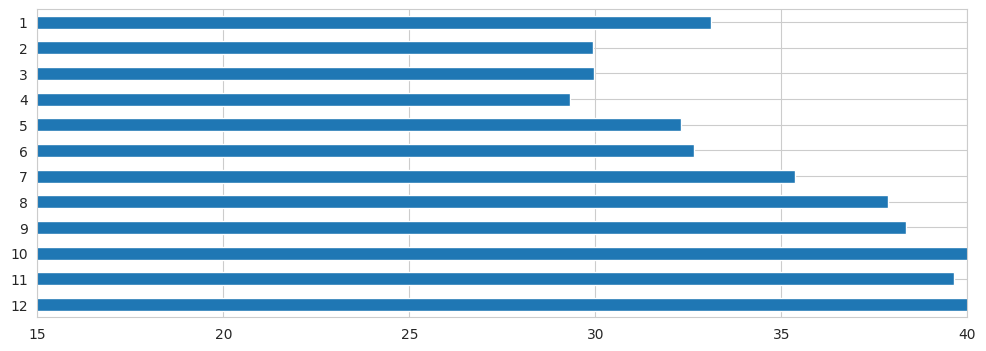

In [ ]:
mi.sum(1).mul(100).iloc[:12].sort_index(ascending=False).plot.barh(figsize=(12, 4), xlim=(15, 40));

In [ ]:
import matplotlib.pyplot as plt  # Import the necessary module
import seaborn as sns

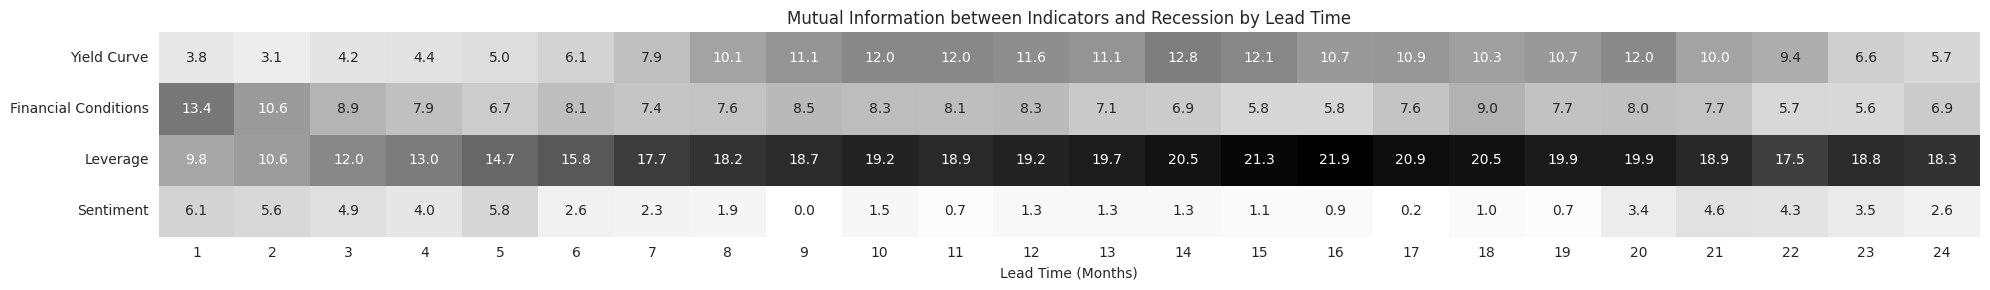

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(mi.rename(columns=col_dict).T*100, cmap='Greys', ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Lead Time (Months)')
ax.set_title('Mutual Information between Indicators and Recession by Lead Time')
fig.tight_layout();

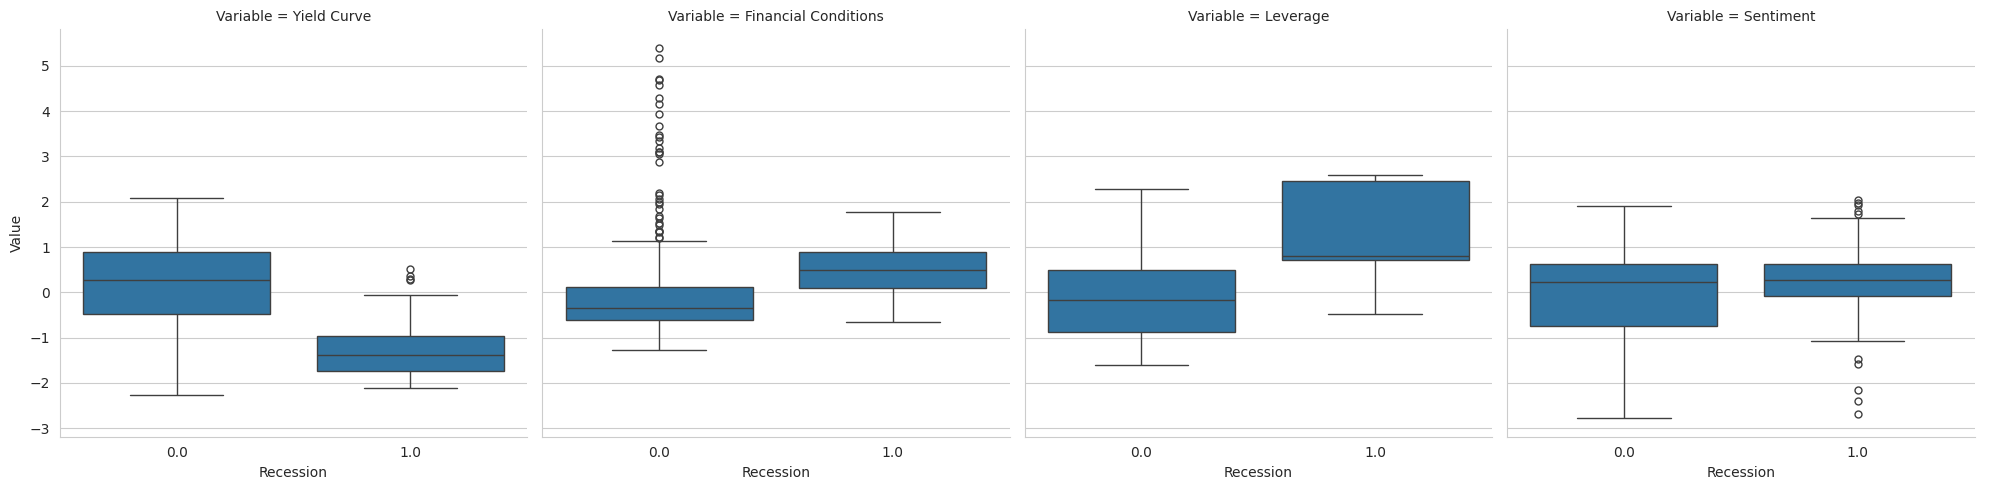

In [ ]:
data[label] = data[label].shift(-12)
data = data.dropna()
data_ = pd.melt(data.rename(columns=col_dict), id_vars='Recession').rename(columns=str.capitalize)
g = sns.catplot(x='Recession', y='Value', col='Variable', data=data_, kind='box');

In [ ]:
X = data.loc[:, features]
y = data[label]

In [ ]:
y.value_counts()

,count
recession,
0.0,396
1.0,49


In [ ]:
data.to_csv('data/recessions.csv')

Load from Disk

In [ ]:
data = pd.read_csv('data/recessions.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 1982-01-31 to 2019-01-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             445 non-null    float64
 1   yield_curve           445 non-null    float64
 2   financial_conditions  445 non-null    float64
 3   leverage              445 non-null    float64
 4   sentiment             445 non-null    float64
dtypes: float64(5)
memory usage: 20.9+ KB


Models

In [ ]:
simple_model = 'recession ~ yield_curve + leverage'
full_model =  simple_model + ' + financial_conditions + sentiment'

# MAP Inference

### Manual Model Specification

In [ ]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with
    # uninformative priors for each parameter

    intercept = pm.Normal('intercept', 0, sigma=100)
    beta_1 = pm.Normal('beta_1', 0, sigma=100)
    beta_2 = pm.Normal('beta_2', 0, sigma=100)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept +
                             beta_1 * data.yield_curve +
                             beta_2 * data.leverage)

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit',
                 p=likelihood,
                 observed=data.recession)

In [ ]:
manual_logistic_model.basic_RVs

[intercept, beta_1, beta_2, logit]

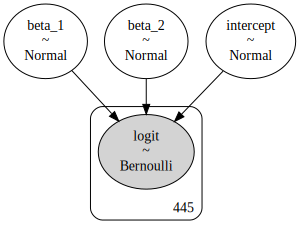

In [ ]:
pm.model_to_graphviz(manual_logistic_model)

### Run Inference

In [ ]:
with manual_logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

Output()

In [ ]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})

In [ ]:
def print_map(result):
    """Converts result values to scalar using .item()."""
    return pd.Series({k: v.item() if isinstance(v, np.ndarray) else v
                     for k, v in result.items()})

In [ ]:
result = {
    'intercept': np.array([1.5]),
    'beta_1': np.array([2.3]),
    'beta_2': np.array([3.7]),
    'dtype': 'float64'
}

# Call the function and print the result
print(print_map(result))

intercept        1.5
beta_1           2.3
beta_2           3.7
dtype        float64
dtype: object


## GLM Model

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(simple_model,
                            data,
                            family=pm.glm.families.Binomial())

AttributeError: module 'pymc' has no attribute 'glm'

In [ ]:
pm.model_to_graphviz(logistic_model)